In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes

Here we're going to go through a basic Naive Bayes classifier. Specifically we're going to build a spam filter. As we've said before, this is a classic use for this kind of classifier and it's not too difficult to set up. The dataset we'll work with is UC Irvine's [SMS spam dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

This dataset has a few nice attributes. Firstly, it's pre-labelled, which is great for our purposes as we don't have to make our own spam/ham labels ('ham' being the common term to denote a message that is not spam). Secondly, the dataset is relatively small, which will allow us to show off one of the great things about Naive Bayes, its ability to train on relatively little data while achieving reasonable accuracy. 

In [24]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
             "master/sms_spam_collection/SMSSpamCollection"
            )
sms_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

So we've loaded up the dataset and we have two columns, a label and a message.

Now, a message isn't really a feature. If you tried to make it one it'd be pretty useless. However, we can engineer features from the message field relatively easily. This kind of feature engineering is a basic version of what we'll cover in the NLP section.

At the most obvious level, a feature from the message can be whether it contains a given word. Let's add those columns to our dataframe. The words chosen below are simply intuited as possibly having something to do with spam. Try some of your own ideas too!

In [27]:
keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    sms_raw[str(key)] = sms_raw.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

sms_raw['congrat'] = sms_raw.message.str.contains('congrat', case=False)

Note that you could add new features to the dataframe simply by adding them to the keywords list. That's much nicer than doing each word manually. If it were more complicated it would probably be worth making a function as well.

Another feature option would be if the message is all uppercase. That seems kind of spammy doesn't it?

In [28]:
sms_raw['allcaps'] = sms_raw.message.str.isupper()


Before we go further, let's turn the spam column into a boolean so we can easily do some statistics to prepare for modeling.

In [29]:
sms_raw['spam'] = (sms_raw['spam'] == 'spam')
# Note that if you run this cell a second time everything will become false.
# So... Don't.
exceptions = ['who', 'what', 'when', 'where', 'why']

for row in sms_raw['spam']:
    for key in exceptions:
        if row and sms_raw.message.str.contains(
            str(key)):
            row = False

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Now, as we covered before one of the main assumptions of Naive Bayes is that the variables fed into the model are independent of each other. Let's check to see how true that is in this case using Pandas' built in correlation matrix function, corr(), and the heatmap from seaborn.

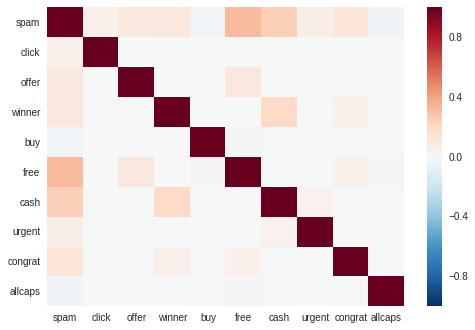

In [12]:
sns.heatmap(sms_raw.corr())

That is actually a great looking plot for us. Most of the words show strong independence from each other. The only exceptions are free:offer and cash:winner. For now, let's keep everything in the dataset.

Before we actually run the model we have to build out our training data. SKLearn required you to specify an outcome (y or dependent variable) and your inputs (x or independent variables). We'll do that below under the titles `data` and `target`.

In [18]:
data = sms_raw[keywords + ['congrat']]
target = sms_raw['spam']

In [19]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 5572 points : 597


Now try adding some of your own features and seeing if you can improve the model's performance. Also try comparing the other types of Naive Bayes Classifier and see which one is best. You can find the function names for training other kinds of Naive Bayes in the [documentation](http://scikit-learn.org/stable/modules/naive_bayes.html). It's a one word change.

## Bayesian Poisoning

When implementing Naive Bayes, there is one more thing you must be aware of. Because Naive Bayes relies on probabilities and these probabilities are often based around obvious keywords it is a vulnerable model. By that we mean that people can manipulate the model. This is done through a process called __Bayesian Poisoning__.

In spam, this would be done through including words in your spam message that would be highly unlikely to be part of a spam message. This would convince the model that the message is legitimate and let it into your inbox or wherever.

Can you think of how you could do that here? Look at some spam messages that your model correctly identified and see if you can reword or rework them to get them classified as ham.